In [2]:
import glob
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing import image 

#### Importazione e normalizzazione del dataset 

In [4]:
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0 
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

y_x_train = x_train[:]

#### Creazione del dataset con disturboi del 65% (con distribuzione gaussiana con deviazione tra 0 e 1 essendo i dati normalizzati)

In [5]:
noise_factor = 0.65 
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale= 1.0 , size= x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale= 1.0 , size= x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

#### Illustrazione features con rumore e senza 

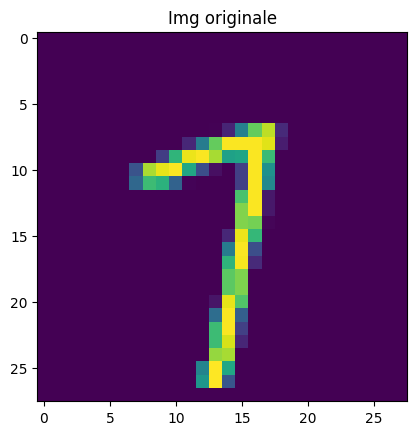

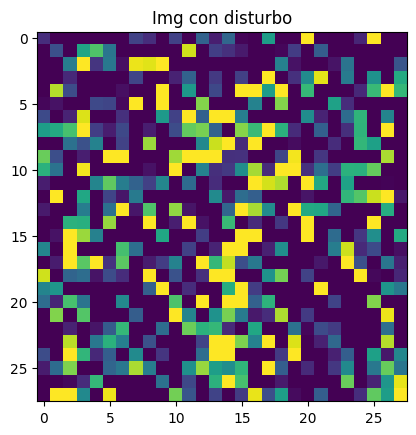

In [6]:
plt.title('Img originale')
plt.imshow(x_train[42])
plt.show()

plt.title('Img con disturbo')
plt.imshow(x_train_noisy[42])
plt.show()

#### Creazione architettura dell'autoencoder e scrittura modello

In [7]:
input_img = Input(shape=(28,28,1))

x = Conv2D(48, 3, activation = 'relu', padding='same')(input_img)
x = MaxPooling2D(2, padding='same')(x) 
x = BatchNormalization()(x)

x = Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
x = MaxPooling2D(2, padding = 'same')(x)
encoder = BatchNormalization()(x)

decoder = Conv2D(64, 3, activation = 'relu', padding  ='same' )(encoder)
x = UpSampling2D(2)(decoder)
x = BatchNormalization()(x)

x = Conv2D(48, 3, activation = 'relu', padding='same')(x)
x = UpSampling2D(2)(x)
x = BatchNormalization()(x)
decoded = Conv2D(1, 3, activation = 'sigmoid', padding = 'same')(x)


autoencoder = Model(input_img, decoded)
optimizer = Nadam(learning_rate = 0.001)
autoencoder.compile(optimizer = optimizer, loss = 'binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 48)        480       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 48)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 48)        192       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        27712     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0     

#### Addestramento del modello 

In [8]:
history = autoencoder.fit(x_train_noisy, x_train, epochs= 100, batch_size = 1024, verbose =2)

Epoch 1/100
59/59 - 144s - loss: 0.4474 - 144s/epoch - 2s/step
Epoch 2/100
59/59 - 145s - loss: 0.1962 - 145s/epoch - 2s/step
Epoch 3/100
59/59 - 143s - loss: 0.1379 - 143s/epoch - 2s/step
Epoch 4/100
59/59 - 145s - loss: 0.1288 - 145s/epoch - 2s/step
Epoch 5/100
59/59 - 141s - loss: 0.1249 - 141s/epoch - 2s/step
Epoch 6/100
59/59 - 140s - loss: 0.1227 - 140s/epoch - 2s/step
Epoch 7/100
59/59 - 141s - loss: 0.1212 - 141s/epoch - 2s/step
Epoch 8/100
59/59 - 143s - loss: 0.1197 - 143s/epoch - 2s/step
Epoch 9/100
59/59 - 139s - loss: 0.1188 - 139s/epoch - 2s/step
Epoch 10/100
59/59 - 139s - loss: 0.1177 - 139s/epoch - 2s/step
Epoch 11/100
59/59 - 139s - loss: 0.1171 - 139s/epoch - 2s/step
Epoch 12/100
59/59 - 135s - loss: 0.1166 - 135s/epoch - 2s/step
Epoch 13/100
59/59 - 133s - loss: 0.1161 - 133s/epoch - 2s/step
Epoch 14/100
59/59 - 149s - loss: 0.1153 - 149s/epoch - 3s/step
Epoch 15/100
59/59 - 132s - loss: 0.1149 - 132s/epoch - 2s/step
Epoch 16/100
59/59 - 137s - loss: 0.1145 - 137s/e

#### Illustrazione dell'errore per epoca 

Text(0, 0.5, 'Loss')

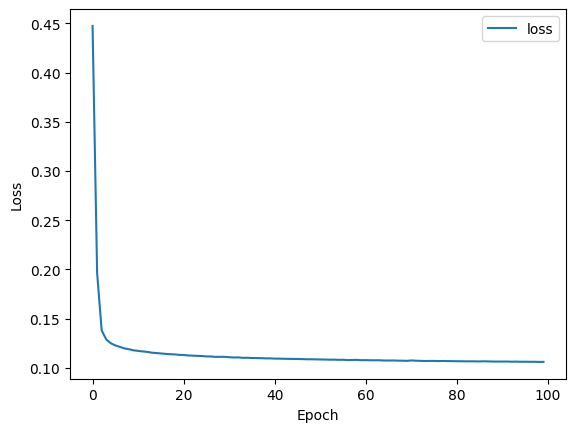

In [9]:
_ , ax = plt.subplots()
ax.plot(history.history['loss'])
ax.legend(['loss'], loc = 0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

#### Locazione in memoria dove sono locati i layer e come e' composta la nostra architettura di rete 

In [10]:
for l in autoencoder.layers:
    print(l)
print(len(autoencoder.layers))

14


#### Costruzione del dataset di immagini codificate utilizzando le immagini del set di validazione

In [14]:
encoder_model = Sequential()
for layer in autoencoder.layers[0:7]:
    encoder_model.add(layer)
encoded_imgs = encoder_model.predict(x_test)

313/313 [==============================] - 2s 6ms/step


#### Visualizazione immagini codificate

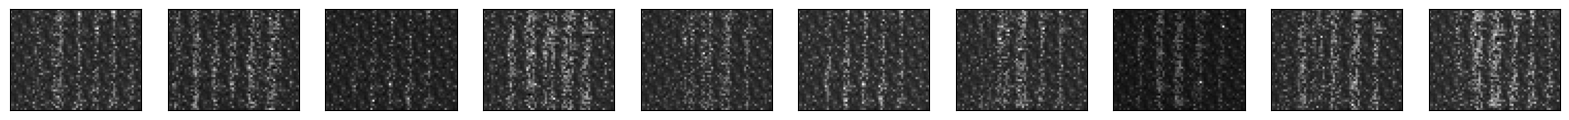

In [15]:
n = 10 
plt.figure(figsize = (20,8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(64, 49).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Visualizzazione delle immagini di test passandole per il disturbatore e poi per l'autoencoder 

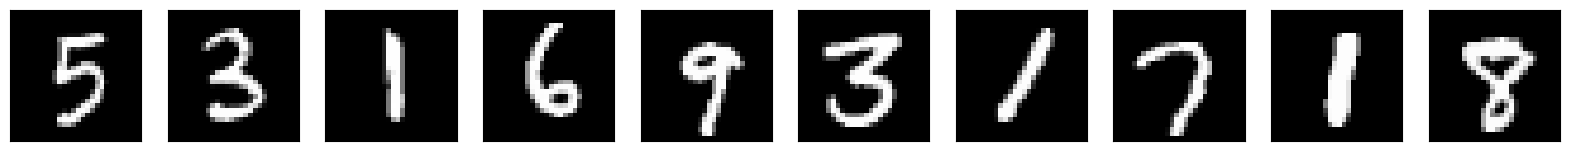

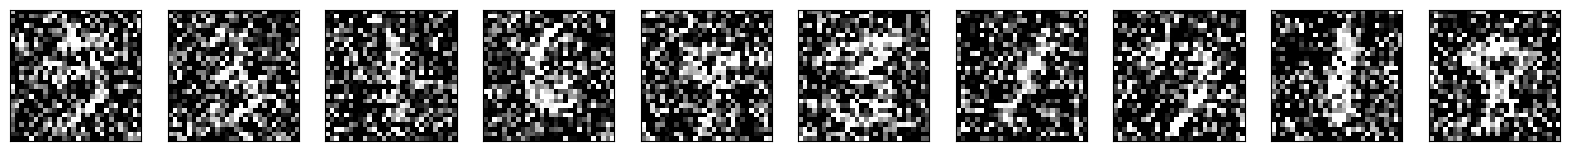

1/1 [==============================] - 0s 24ms/step


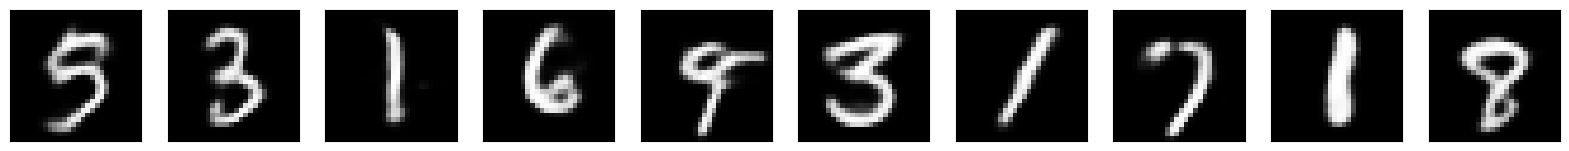

In [21]:
n = 10 
idxs = []
plt.figure(figsize = (20, 8))
for i in range (n):
    ax = plt.subplot(1, n, i + 1)
    idx = np.random.rand(1) * 10000
    idxs.append(int(idx))
    plt.imshow(x_test[idxs[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize = (20,8))
for i in range(n):
    ax = plt.subplot(1, n , i+1)
    plt.imshow(x_test_noisy[idxs[i]].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20,8))
for i in range(n):
    ax = plt.subplot(1, n, i +1)
    new_img = autoencoder.predict(x_test_noisy[idxs[i]].reshape(1,28,28,1))
    plt.imshow(new_img.reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()